## Import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import nltk
import zipfile
import string
import wget
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

## Parsing the Data

In [2]:
with open('data/data.json') as i:
  data = json.load(i)

In [3]:
#getting all the data to lists
tags = []
inputs = []
responses = {}
for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [4]:
#converting to dataframe
data = pd.DataFrame({
    "inputs":inputs,
    "tags":tags
    })
print("Data Shape\nrow: %d\ncolumns: %d"%(data.shape[1], data.shape[0]))
data.head(10)

Data Shape
row: 2
columns: 1056


,inputs,tags
0,hello,greeting
1,halo,greeting
2,hola,greeting
3,hey,greeting
4,hoy,greeting
5,yo,greeting
6,ahoy,greeting
7,sup,greeting
8,hey there,greeting
9,hi,greeting


## Train Test Split

In [5]:
# Global Variable
sentences = data['inputs']
labels = data['tags']
train_size = 0.8
EMBEDDING_DIM = 100
MAXLEN = 24
TRUNCATING = 'post'
PADDING = 'post'

In [6]:
from sklearn.model_selection import train_test_split


def train_val_split(sentences, labels, train_size):
    train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(
        sentences, labels, train_size=train_size, random_state=10)
    return train_sentences, validation_sentences, train_labels, validation_labels


In [7]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(
    sentences, labels, train_size)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")


There are 844 sentences for training.

There are 844 labels for training.

There are 212 sentences for validation.

There are 212 labels for validation.


## Data Cleaning

#### Removing Punctuations

In [8]:
train_sentences = train_sentences.apply(
    lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_sentences = train_sentences.apply(lambda wrd: ''.join(wrd))

train_sentences.head(10)

989                                                ok bye
802                   tell me how to refund flight ticket
924                           how to regain travel credit
504     where i can get information about reschedule h...
661                              hotel ticket cancelation
104                credit card transaction not successful
828                  whats the call center contact number
524                   i think i wanna reschedule my hotel
750                                cancel boarding ticket
1046                                         im impressed
Name: inputs, dtype: object

#### Tokenizer

In [9]:
def fit_tokenizer(data, oov_token):
  # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
  tokenizer = Tokenizer(num_words=1000, oov_token=oov_token)

  # Fit the tokenizer to the training sentences
  tokenizer.fit_on_texts(data)

  return tokenizer


In [10]:
tokenizer = fit_tokenizer(train_sentences, "<OOV>")

word_index = tokenizer.word_index
vocab_size = len(word_index)
print("number of unique words: ", vocab_size)

number of unique words:  402


#### Sequences, truncating and padding

In [11]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences, )

    # Pad the sequences using the correct padding, truncating and maxlen
    x_train = pad_sequences(sequences, maxlen=maxlen,
                            padding=padding, truncating=truncating)

    return x_train


In [12]:
train_pad_trunc_seq = seq_pad_and_trunc(
    train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(
    val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(
    f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(
    f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")


Padded and truncated training sequences have shape: (844, 24)

Padded and truncated validation sequences have shape: (212, 24)


In [13]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

#### Encoding

In [14]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.fit_transform(val_labels)

In [15]:
tags_unique_length = le.classes_.shape[0]
print("number of tags: ", tags_unique_length)


number of tags:  13


## Embedding

In [ ]:
# download it
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

In [21]:
with zipfile.ZipFile('tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('tmp/glove')

In [24]:
# Define path to file containing the embeddings
GLOVE_FILE = 'tmp/glove/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [25]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vocab_size+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

## Modelling

In [26]:
def create_nlp_model(vocab_size, output_length, embedding_dim, embedding_matrix, maxlen):

  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size+1, embedding_dim,
                                input_length=maxlen, weights=[embedding_matrix], trainable=True),
      tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(64,  return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(
          1e-6), activity_regularizer=tf.keras.regularizers.L1(1e-6)),
      tf.keras.layers.Dropout(0.01),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(
          1e-6), activity_regularizer=tf.keras.regularizers.L2(1e-6)),
      tf.keras.layers.Dropout(0.015),
      tf.keras.layers.Dense(output_length, activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])
  return model


In [27]:
model = create_nlp_model(vocab_size, tags_unique_length,
                         EMBEDDING_DIM, EMBEDDINGS_MATRIX, MAXLEN)
                         
model.summary()
history = model.fit(train_pad_trunc_seq, train_labels,
                    epochs=75, validation_data=(val_pad_trunc_seq, val_labels))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 100)           40300     
                                                                 
 bidirectional (Bidirectiona  (None, 24, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                2

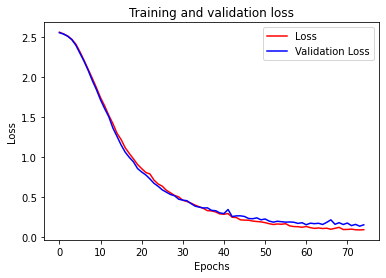

In [28]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(loss, 'r')
plt.plot(val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()


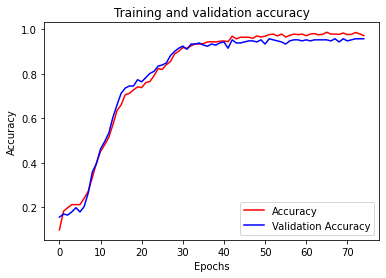

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(acc, 'r')
plt.plot(val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()


## Deploy

In [ ]:
# # with pickle
# import pickle
# pickle.dump(model, open('model.pkl', 'wb'))

# # with keras
# !mkdir - p saved_model
# model.save("model.h5")